# unified code for python file in backend

model.py

In [1]:
import numpy as np
import torch
import cv2
import lungs_finder as lf #pip install git+https://github.com/dirtmaxim/lungs-finder
import matplotlib.pyplot as plt

from skimage.color import rgb2gray, rgba2rgb, gray2rgb

from albumentations.core.composition import *
from albumentations.pytorch import ToTensor, ToTensorV2
from albumentations.augmentations.transforms import *

threshold = 0.5

def normalizer(img, **params):
    img = img.astype(np.float32)
    if img.max()>255:
        img/=65535.
    elif img.max()>1:
        img/=255.
    return (img-0.5)*2

preprocess = Compose([Lambda(image=normalizer), Resize(224, 224), ToTensorV2()])

# ---------- HELPERS FOR VISUALIZATION
"""
gradcam wrapperg
"""
class GradCam:
    def __init__(self, model, layers):
        self.model = model
        self.layers = layers
        self.hooks = []
        self.fmap_pool = dict()
        self.grad_pool = dict()

        def forward_hook(module, input, output):
            self.fmap_pool[module] = output.detach().cpu()
        def backward_hook(module, grad_in, grad_out):
            self.grad_pool[module] = grad_out[0].detach().cpu()
        
        for layer in layers:
            self.hooks.append(layer.register_forward_hook(forward_hook))
            self.hooks.append(layer.register_backward_hook(backward_hook))

    def close(self):
        for hook in self.hooks:
            hook.remove()

    def __enter__(self):
        return self

    def __exit__(self, type, value, traceback):
        self.close()

    def __call__(self, *args, **kwargs):
        self.model.zero_grad()
        return self.model(*args, **kwargs)

    def get(self, layer):
        assert layer in self.layers, f'{layer} not in {self.layers}'
        fmap_b = self.fmap_pool[layer] # [N, C, fmpH, fmpW]
        grad_b = self.grad_pool[layer] # [N, C, fmpH, fmpW]

        grad_b = torch.nn.functional.adaptive_avg_pool2d(grad_b, (1, 1)) # [N, C, 1, 1]
        gcam_b = (fmap_b * grad_b).sum(dim=1, keepdim=True) # [N, 1, fmpH, fmpW]
        gcam_b = torch.nn.functional.relu(gcam_b)

        return gcam_b
    
"""
guidedbackprop wrapper
"""
class GuidedBackPropogation:
    def __init__(self, model):
        self.model = model
        self.hooks = []

        def backward_hook(module, grad_in, grad_out):
            if isinstance(module, torch.nn.ReLU):
                return tuple(grad.clamp(min=0.0) for grad in grad_in)

        for name, module in self.model.named_modules():
            self.hooks.append(module.register_backward_hook(backward_hook))

    def close(self):
        for hook in self.hooks:
            hook.remove()

    def __enter__(self):
        return self

    def __exit__(self, type, value, traceback):
        self.close()

    def __call__(self, *args, **kwargs):
        self.model.zero_grad()
        return self.model(*args, **kwargs)
    
    def get(self, layer):
        return layer.grad.cpu()

"""
gradcam predictor (also returns model prediction)
"""
def get_grad(model,img):

    torch.set_grad_enabled(True)
    
    gcam = GradCam(model, [model.features])

    out = gcam(img)

    mask = (out>=threshold)[0]
    out[0:1, mask].sum().backward()

    grad = gcam.get(model.features)[0:1]
    grad = torch.nn.functional.interpolate(grad, [224,224], mode='bilinear', align_corners=False)

    # we return everything only for 1 image
    return out[0], grad[0,0,:,:]

"""
guided backprop predictor
"""
def get_gbprop(model, img):

    torch.set_grad_enabled(True)
    
    gdbp = GuidedBackPropogation(model)
    inp_b = img.requires_grad_() # Enable recording inp_b's gradient
    out_b = gdbp(inp_b)
    mask = (out_b>=threshold)[0]
    out_b[0:1, mask].sum().backward()

    grad_b = gdbp.get(img)[0:1] # [N, 3, inpH, inpW]
    grad_b = grad_b.mean(dim=1, keepdim=True).abs() # [N, 1, inpH, inpW]
        
    return grad_b.squeeze()
    
def normalize(img):
    out = img-img.min()
    out/=(out.max()+1e-7)
    return out
    

# --------- END OF HELPERS FOR VISUALIZATION--------


# --------- model functions
    
def load_model(ckpt_path):
    """
    function us used to load our model from checkpoint and return it
    """
  
    from densenet import densenet121

    model = densenet121(num_classes=14)

    class Fixer(torch.nn.Module):
        def __init__(self, model):
            super(Fixer, self).__init__()
            self.model = model

    model = Fixer(model)
    model.load_state_dict(torch.load(ckpt_path)['state_dict'])
    model = model.model
    
    model.train()
    
    return model


def convert_prediction_to_pathology(y_pred):
    """
    this function is used to convert vector of anwers to vector of string representations
    e.g. [1,1,0,0,0,0,...] to ['Atelec...','Cadioomeg...']
    """
    pathologies = np.asarray(['Atelectasis',
                 'Cardiomegaly',
                 'Consolidation',
                 'Edema',
                 'Effusion',
                 'Emphysema',
                 'Fibrosis',
                 'Hernia',
                 'Infiltration',
                 'Mass',
                 'Nodule',
                 'Pleural_Thickening',
                 'Pneumonia',
                 'Pneumothorax'])
    
    y_pred = y_pred.clone().detach().cpu().numpy()
    mask = (y_pred>=threshold).astype(bool)
    
    return pathologies[mask].tolist()

def prepare_image(path_to_image):
    """
    image preprocessor
    
    Args:
        path_to_image: string with image location
    """
    image = cv2.imread(path_to_image).astype(float)
    
    if image.ndim==3:
        if image.shape[2]==4:
            image = rgb2gray(rgba2rgb(image))
        else:
            image = rgb2gray(image)
    image = np.expand_dims(image,-1)
    
    image = preprocess(image=image)['image'].unsqueeze(0)
    return image

def predict_visual(model, path_to_image, isCuda = False):
    """
    function is used to predict labels and visualise image
    
    Args:
        path_to_image: str with image location (0-255)
        model: our loaded model
        isCuda: bool flag, set to Treu to run on gpu
    """
    # sadly, gbrop can not be extract at the same time as gradcam
    # so we have to do two predictions for the same image
    image = prepare_image(path_to_image)
    
    if isCuda:
        image = image.to(torch.device('cuda'))
        model.to(torch.device('cuda'))
    
    image.require_grad = True
    pred, gcam = get_grad(model, image)
    gbprop = get_gbprop(model, image)
    
    # plt.imshow((np.repeat(normalize(img.squeeze().detach().cpu().numpy())[:,:,np.newaxis],3,2)+plt.cm.hot(normalize(gbprop*grad).detach().cpu().numpy())[:,:,:3])/2)
    visualization = normalize((gbprop*gcam).detach().cpu().numpy())
    visualization = normalize(visualization)
    
    orig = (normalize(image.detach().cpu().numpy()[0,0,:,:])*255).astype(np.uint8)

    visualization = plt.get_cmap('hot')(visualization)[:,:,:3]

    final = np.zeros(visualization.shape)
    right_lung_haar_rectangle = lf.find_right_lung_haar(orig)
    left_lung_haar_rectangle = lf.find_left_lung_haar(orig)

    if (right_lung_haar_rectangle is not None) and (left_lung_haar_rectangle is not None):
        x, y, width, height = right_lung_haar_rectangle
        final[y:y + height, x:x + width] = visualization[y:y + height, x:x + width]
        x, y, width, height = left_lung_haar_rectangle
        final[y:y + height, x:x + width] = visualization[y:y + height, x:x + width]
    else:
        final = visualization

    final = normalize(final + \
        cv2.cvtColor(orig, cv2.COLOR_GRAY2RGB).astype(
            np.float32)/255)
    
    return pred, final

def predict(model, path_to_image, isCuda = False):
    """
    used to predit labels only (to speed up the process)
    isCuda: bool flag, set to Treu to run on gpu
    """
    image = prepare_image(path_to_image)
    
    if isCuda:
        image = image.to(torch.device('cuda'))
        model.to(torch.device('cuda'))
    
    return model(image)[0]  

In [2]:
model = load_model("./densenet121nobn.ckpt")
model.train()


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): Identity()
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): Identity()
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): Identity()
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): Identity()
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): Identity()
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      

In [3]:

pred, vis = predict_visual(model,"/home/alexander/work/hackathon/chest-14/images/00014022_084.png") # cardiomegaly
pred

tensor([1.7246e-18, 9.9999e-01, 1.5775e-13, 5.4511e-20, 1.4000e-06, 7.5157e-26,
        2.3458e-08, 5.2977e-20, 1.2949e-08, 3.1674e-08, 5.8204e-08, 3.1360e-05,
        4.7115e-19, 1.4685e-15], grad_fn=<SelectBackward>)

In [4]:
vis

array([[[0.04153301, 0.0150047 , 0.0150047 ],
        [0.04153301, 0.0150047 , 0.0150047 ],
        [0.04153301, 0.0150047 , 0.0150047 ],
        ...,
        [0.04403379, 0.01750548, 0.01750548],
        [0.04403379, 0.01750548, 0.01750548],
        [0.04403379, 0.01750548, 0.01750548]],

       [[0.04153301, 0.0150047 , 0.0150047 ],
        [0.04153301, 0.0150047 , 0.0150047 ],
        [0.04153301, 0.0150047 , 0.0150047 ],
        ...,
        [0.04403379, 0.01750548, 0.01750548],
        [0.04403379, 0.01750548, 0.01750548],
        [0.04403379, 0.01750548, 0.01750548]],

       [[0.04153301, 0.0150047 , 0.0150047 ],
        [0.04153301, 0.0150047 , 0.0150047 ],
        [0.04153301, 0.0150047 , 0.0150047 ],
        ...,
        [0.04403379, 0.01750548, 0.01750548],
        [0.04153301, 0.0150047 , 0.0150047 ],
        [0.04403379, 0.01750548, 0.01750548]],

       ...,

       [[0.32162075, 0.29509244, 0.29509244],
        [0.31661918, 0.29009087, 0.29009087],
        [0.3141184 , 0

In [5]:
model.train()
pred = predict(model,"/home/alexander/work/hackathon/chest-14/images/00014022_084.png")
pred

tensor([1.7246e-18, 9.9999e-01, 1.5775e-13, 5.4511e-20, 1.4000e-06, 7.5157e-26,
        2.3458e-08, 5.2977e-20, 1.2949e-08, 3.1674e-08, 5.8204e-08, 3.1360e-05,
        4.7115e-19, 1.4685e-15], grad_fn=<SelectBackward>)

In [6]:
convert_prediction_to_pathology(pred)

['Cardiomegaly']

In [7]:
vis.max()

0.9999999362300245

In [8]:
import matplotlib.pyplot as plt

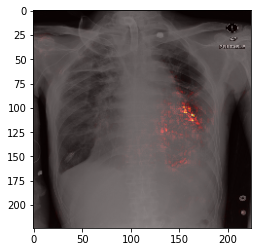

In [9]:
plt.imshow(vis)

# test prediction on 32 images

In [10]:
import pandas as pd
df_only_labels = pd.read_csv('/home/alexander/work/hackathon/chest-14/Data_Entry_2017.csv')
df_only_labels

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143
...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168


In [11]:
pathologies = ['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']


labels = []
for pathology in pathologies:
    labels.append(df_only_labels['Finding Labels'].str.contains(pathology).values)

labels = np.asarray(labels).T
labels = labels.astype(int)

labels

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [12]:
np.zeros(3)==np.asarray([0,0,0])

array([ True,  True,  True])

In [13]:
import matplotlib.pyplot as plt
from tqdm import tqdm

y_pred = []
y_true = []
wrong = 0
for i, img in tqdm(df_only_labels.iterrows()):
    pred = predict(model,'/home/alexander/work/hackathon/chest-14/images/'+img['Image Index'], isCuda=True).detach().cpu().numpy()
    pred = (pred>=0.5).astype(int)
    y_pred.append(pred)
    y_true.append(labels[i])
    if ((pred!=labels[i]).sum())!=0:
        print(pred)
        print(labels[i])
        wrong+=1
        print(wrong)

494it [00:33, 17.43it/s]

[0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 1 0 0 0 0 0 0 0 0 0 0 0]
1


760it [00:51, 18.12it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0]
2


984it [01:07, 16.07it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
3


1162it [01:18, 17.40it/s]

[0 1 0 0 1 0 0 0 0 0 0 0 0 0]
[0 1 0 0 1 0 0 1 0 0 0 0 0 0]
4


1768it [01:59, 16.24it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1]
5


2092it [02:21, 15.22it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 1 0 0 0 1 0 0 0 0 0]
6


2556it [02:52, 17.87it/s]

[0 0 0 0 1 0 0 0 0 0 0 0 0 0]
[1 0 0 0 1 0 0 0 0 0 0 0 0 0]
7


2956it [03:19, 14.10it/s]

[0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
8


3094it [03:29, 11.34it/s]

[0 0 0 0 0 0 0 0 1 0 1 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
9


3120it [03:31, 12.04it/s]

[0 0 0 1 0 1 0 0 1 0 0 0 0 0]
[0 0 0 0 0 1 0 0 1 0 0 0 0 0]
10


3640it [04:06, 15.18it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0]
11


3766it [04:15, 10.36it/s]

[0 0 0 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
12


3906it [04:24, 18.16it/s]

[0 0 0 0 0 0 0 0 0 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 1 0 0]
13


4690it [05:17, 18.47it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 1 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
14


5254it [05:56, 11.63it/s]

[1 0 0 0 1 0 0 0 1 0 0 1 0 0]
[0 0 0 0 1 0 0 0 1 0 0 1 0 0]
15


5268it [05:56, 17.23it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1]
16


6304it [07:06, 16.98it/s]

[0 0 0 0 0 0 0 0 0 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0 1]
17


6530it [07:22, 14.62it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0]
18


7494it [08:25, 18.42it/s]

[0 0 0 0 0 0 0 0 1 0 1 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
19


7572it [08:30, 18.85it/s]

[0 0 0 0 0 0 0 0 1 0 1 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
20


7583it [08:31, 18.15it/s]

[0 0 0 0 0 0 1 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 1 0 0 0 0 1]
21


7904it [08:51, 18.64it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0]
22
[0 0 0 0 0 0 1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
23


8508it [09:30, 19.24it/s]

[0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
24


8864it [09:52, 18.02it/s]

[0 1 0 0 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0]
25


9061it [10:05, 19.69it/s]

[1 0 0 0 0 0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1]
26


9085it [10:06, 11.96it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 0 0 1 0 0 1]
27


9498it [10:33, 10.09it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0]
28


9782it [10:50, 20.00it/s]

[0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 1 0 0 0 0 0 0 0]
29


9790it [10:51, 18.03it/s]

[0 0 0 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 1 0 0 0 0 0 0 0 0 0]
30


9985it [11:03, 18.17it/s]

[0 0 0 0 1 0 0 0 0 0 0 0 0 0]
[1 0 0 0 1 0 0 0 0 0 0 0 0 0]
31


10516it [11:37, 17.30it/s]

[1 0 0 0 1 0 0 0 1 0 1 0 0 0]
[0 0 0 0 1 0 0 0 1 0 1 0 0 0]
32


10652it [11:46, 17.83it/s]

[0 0 0 0 0 0 0 0 0 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 1 0 0 0]
33


10973it [12:06, 18.73it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34


11070it [12:12, 14.82it/s]

[1 0 0 0 0 0 0 0 1 0 1 0 0 0]
[1 0 0 0 0 0 0 0 1 0 1 0 0 1]
35


11480it [12:38, 15.79it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0]
36


11512it [12:41, 16.39it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
37


11654it [12:50, 18.06it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
38


11662it [12:51, 17.83it/s]

[1 0 1 0 0 1 0 0 1 0 0 0 0 1]
[1 0 1 0 0 1 0 0 0 0 0 0 0 1]
39


11856it [13:04, 17.04it/s]

[0 0 0 0 0 0 1 0 0 0 0 0 0 1]
[0 0 0 0 0 0 1 0 0 1 0 0 0 1]
40


13020it [14:25, 14.27it/s]

[0 0 0 0 0 0 0 0 0 0 1 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41


13068it [14:28, 11.91it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 1 0 0 0 0]
42


13180it [14:35, 16.94it/s]

[1 0 1 0 1 0 0 0 0 0 0 0 0 0]
[1 0 0 0 1 0 0 0 0 0 0 0 0 0]
43


13724it [15:13, 16.91it/s]

[1 0 0 0 1 0 0 0 0 0 1 0 0 0]
[1 0 0 0 1 0 0 0 0 0 0 0 0 0]
44


14472it [16:05, 14.67it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 1 0 0 0 0]
45


14684it [16:19, 17.44it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1]
46


15052it [16:45, 17.80it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1]
47


15122it [16:49, 18.27it/s]

[0 0 0 0 0 0 0 0 1 0 1 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
48


15166it [16:53, 16.49it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 1 0 0 0 1 0 0 0 0 0]
49


15438it [17:11, 16.00it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
50


15606it [17:23, 10.51it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
51


16092it [17:57, 17.41it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0]
52


16144it [18:00, 17.57it/s]

[0 0 1 1 0 0 0 0 1 1 0 0 0 0]
[0 0 1 0 0 0 0 0 1 1 0 0 0 0]
53


16516it [18:26, 10.96it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0]
54


16590it [18:31, 14.87it/s]

[0 0 0 0 0 0 0 0 1 0 1 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0]
55


17118it [19:08, 16.58it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
56


17130it [19:09, 17.13it/s]

[0 0 1 0 0 0 0 0 0 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0]
57


17200it [19:14, 16.86it/s]

[1 0 0 0 1 0 0 0 1 0 0 0 0 0]
[0 0 0 0 1 0 0 0 1 0 0 0 0 0]
58


17993it [20:08, 17.36it/s]

[1 0 0 0 0 0 0 0 1 0 0 0 0 0]
[1 0 0 0 0 0 0 0 1 0 0 1 0 0]
59


18013it [20:09, 17.26it/s]

[0 0 1 0 0 0 0 0 1 0 0 0 1 0]
[0 0 1 0 0 0 0 0 1 0 0 1 1 0]
60


18041it [20:12, 16.03it/s]

[0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
61


18155it [20:20, 16.26it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0 0 0 0 0]
62


18295it [20:29, 16.77it/s]

[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 1 0 0 0 0 0 0 0 0 0]
63


18537it [20:46, 15.30it/s]

[0 0 0 1 1 0 0 0 0 0 0 0 1 0]
[0 0 0 1 1 0 0 0 0 0 0 0 0 0]
64


19073it [21:24, 17.63it/s]

[0 1 0 0 1 0 0 0 1 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0 0 0 0 0]
65


20125it [22:36, 13.56it/s]

[0 0 0 0 1 0 0 0 1 0 1 0 0 0]
[0 0 0 0 1 0 0 0 0 0 1 0 0 0]
66


20231it [22:44, 15.74it/s]

[0 0 1 0 0 0 0 0 1 0 1 0 0 0]
[0 0 1 0 0 0 0 0 1 0 0 0 0 0]
67


20515it [23:03, 18.13it/s]

[1 0 1 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
68


20737it [23:18, 16.83it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69


21249it [23:53, 14.09it/s]

[0 0 0 0 0 0 0 0 1 0 1 0 0 1]
[0 0 1 0 0 0 0 0 1 0 1 0 0 1]
70


22254it [25:03, 17.37it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
71


22944it [25:51, 17.56it/s]

[0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
72


23312it [26:17, 14.38it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0]
73


24522it [27:42, 12.35it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 1]
74


24750it [27:58, 13.97it/s]

[0 0 0 0 1 0 0 0 0 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0]
75


25662it [29:01, 16.39it/s]

[1 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
76


25680it [29:02, 11.09it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0]
77


25900it [29:18, 13.86it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
78


26102it [29:33, 16.29it/s]

[0 0 0 0 1 0 0 0 0 0 1 0 0 0]
[1 0 0 0 1 0 0 0 0 0 1 0 0 0]
79


26170it [29:37, 17.36it/s]

[1 0 0 0 1 0 0 0 0 0 0 0 0 0]
[1 0 0 0 1 0 0 0 0 0 0 0 0 1]
80


27165it [30:47, 17.36it/s]

[1 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
81


27177it [30:47, 16.32it/s]

[0 0 0 0 1 0 0 0 1 0 1 0 0 0]
[0 0 0 0 0 0 0 0 1 0 1 0 0 0]
82


28163it [31:57, 12.36it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0]
83


28377it [32:11, 13.24it/s]

[0 0 0 0 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
84


28752it [32:45, 15.30it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
85


29062it [33:09, 13.92it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0]
86


29356it [33:32, 15.16it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
87


29474it [33:42, 13.04it/s]

[0 0 0 0 0 0 0 0 0 0 0 1 0 1]
[0 0 0 0 1 0 0 0 1 0 0 0 0 1]
88


29684it [33:58,  9.05it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
89


30625it [35:17,  6.84it/s]

[0 0 1 0 0 0 0 0 0 0 1 0 0 0]
[0 0 1 0 0 0 0 0 0 1 1 0 0 0]
90


30737it [35:25, 15.93it/s]

[0 0 0 0 0 0 1 0 0 1 0 0 0 0]
[0 0 0 0 0 0 1 1 0 1 0 0 0 0]
91


30862it [35:37,  8.71it/s]

[1 0 0 0 1 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
92


31058it [35:53, 15.10it/s]

[0 0 0 1 0 0 0 0 1 0 1 0 0 0]
[0 0 1 1 0 0 0 0 1 0 1 0 0 0]
93


31269it [36:11,  9.71it/s]

[1 0 1 0 0 0 0 0 0 1 0 0 0 0]
[1 0 1 0 0 0 0 0 0 1 0 0 1 0]
94


32218it [37:28, 13.47it/s]

[1 0 1 0 1 0 0 0 0 0 0 0 0 0]
[1 0 1 0 1 0 0 0 1 0 0 0 0 0]
95


32440it [37:45, 15.16it/s]

[0 0 0 0 0 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 1 0 0 0 0 0]
96


32902it [38:19, 13.23it/s]

[0 0 0 0 0 0 0 0 0 0 1 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97


33167it [38:38, 17.19it/s]

[0 0 0 0 0 0 0 0 1 0 1 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
98


33239it [38:44, 12.57it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1]
99


33281it [38:47, 15.84it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
100


33842it [39:29, 15.54it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0]
101


33894it [39:33, 17.06it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0]
102


33926it [39:35, 14.98it/s]

[0 0 0 1 0 0 0 0 1 0 0 0 0 0]
[0 0 0 1 0 0 0 0 0 0 0 0 0 0]
103


34046it [39:43, 18.15it/s]

[0 0 0 1 1 0 0 0 1 0 0 0 1 0]
[0 0 0 1 1 0 0 0 1 0 0 0 0 0]
104


34970it [40:48, 17.88it/s]

[1 0 0 0 0 0 0 0 1 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
105


35170it [41:03, 10.51it/s]

[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 1]
106


35318it [41:15, 12.84it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
107


35330it [41:16, 17.56it/s]

[1 0 0 0 0 0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1]
108


36162it [42:15, 18.28it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
109


36728it [43:00, 12.35it/s]

[1 0 0 0 1 0 0 0 1 0 0 0 0 0]
[1 0 0 0 1 0 0 0 1 1 0 0 0 0]
110


37287it [43:46,  6.95it/s]

[1 0 0 0 1 0 0 0 0 0 0 1 0 0]
[0 0 0 0 1 0 0 0 0 0 0 1 0 0]
111


38206it [45:00, 15.83it/s]

[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
112


39117it [46:14, 14.33it/s]

[0 0 0 0 0 0 0 1 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
113


40893it [48:38, 11.82it/s]

[0 0 0 0 0 0 0 0 1 0 1 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0]
114


40995it [48:46, 13.03it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0]
115


41310it [49:12, 13.94it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0]
116


42017it [50:11,  9.53it/s]

[0 0 0 0 0 1 0 0 1 1 0 0 0 0]
[0 0 0 0 0 1 0 0 0 1 0 0 0 0]
117


42079it [50:16, 12.52it/s]

[0 0 1 0 1 0 0 0 1 0 0 0 0 0]
[0 0 1 0 1 0 0 0 0 0 0 0 0 0]
118


42326it [50:36, 11.49it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0]
119


43034it [51:33, 10.29it/s]

[0 0 1 0 0 0 0 0 0 0 1 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0]
120


43847it [52:38, 11.56it/s]

[0 0 0 0 0 0 0 0 0 1 1 1 0 0]
[0 0 0 0 0 0 0 0 0 1 0 1 0 0]
121


44024it [52:52, 15.39it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1]
122


44207it [53:07, 13.53it/s]

[1 0 0 0 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0]
123


44310it [53:16, 10.40it/s]

[1 0 0 0 1 0 0 0 1 0 1 0 0 0]
[1 0 0 0 1 0 0 0 0 0 1 0 0 0]
124


44360it [53:20, 13.26it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0]
125


44462it [53:28,  9.72it/s]

[1 0 0 0 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0]
126


44500it [53:31, 14.66it/s]

[0 0 0 0 0 0 0 0 0 1 0 0 0 0]
[0 0 0 0 0 0 1 0 0 1 0 0 0 0]
127


44742it [53:52, 12.84it/s]

[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
128


44796it [53:56, 11.82it/s]

[0 0 0 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
129


45813it [55:14, 13.78it/s]

[0 0 0 0 0 0 0 0 1 1 1 0 0 0]
[0 0 0 0 0 0 0 0 1 1 0 0 0 0]
130


46190it [55:41, 13.78it/s]

[0 0 1 0 1 0 0 0 0 0 0 0 0 0]
[0 0 1 0 1 0 0 0 0 0 0 0 0 1]
131


46694it [56:15, 16.51it/s]

[0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[1 0 1 0 1 0 0 0 0 0 0 0 0 0]
132


47006it [56:36, 17.60it/s]

[0 0 0 0 0 0 0 0 1 1 0 0 0 0]
[0 0 0 0 1 0 0 0 1 1 0 0 0 0]
133


47308it [56:57,  9.49it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 0 0]
134


47617it [57:18, 16.14it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 1]
[0 0 0 0 1 0 0 0 0 0 0 0 0 1]
135


47687it [57:23, 17.93it/s]

[1 0 1 0 0 0 0 0 0 1 0 0 0 0]
[1 0 0 0 0 0 0 0 0 1 0 0 0 0]
136


47823it [57:33,  8.56it/s]

[0 0 0 0 0 0 0 0 0 0 1 1 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 0 0]
137


48699it [58:32, 17.54it/s]

[0 0 0 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
138


48979it [58:51, 14.78it/s]

[0 0 0 0 1 0 1 0 1 1 0 0 0 0]
[0 0 0 0 1 0 1 0 0 1 0 0 0 0]
139


49893it [59:53, 18.07it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
140


50095it [1:00:07, 16.29it/s]

[1 0 0 0 0 0 0 0 0 0 1 0 0 0]
[1 0 0 0 0 0 0 0 0 1 1 0 0 0]
141


50293it [1:00:20, 18.06it/s]

[1 0 0 0 1 0 0 0 1 1 0 1 0 0]
[1 0 0 0 0 0 0 0 1 1 0 1 0 0]
142


50671it [1:00:46, 17.83it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0]
143


51233it [1:01:23, 15.14it/s]

[1 1 0 0 1 0 0 0 0 0 0 0 0 0]
[1 1 0 0 0 0 0 0 0 0 0 0 0 0]
144


51327it [1:01:29, 16.87it/s]

[1 0 1 0 0 0 0 0 1 0 0 0 0 0]
[1 0 1 0 1 0 0 0 1 0 0 0 0 0]
145


52652it [1:03:03, 17.23it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1]
146


52896it [1:03:20, 14.93it/s]

[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
147


53519it [1:04:04, 13.46it/s]

[0 1 0 0 0 0 0 0 1 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0 0 0 0 0]
148


54123it [1:04:47, 13.98it/s]

[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
149


54443it [1:05:10, 10.74it/s]

[0 0 1 0 0 0 0 0 0 1 0 0 0 0]
[0 0 1 0 1 0 0 0 0 1 0 0 0 0]
150


54583it [1:05:20, 17.13it/s]

[0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 1 0 0 0 0]
151


55127it [1:05:58, 17.00it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1]
152


56169it [1:07:31, 15.26it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
153


56479it [1:07:59, 15.33it/s]

[0 0 0 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 0 0 0 0 0 0 0 0 0 1]
154


56926it [1:08:34, 15.43it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0]
155


57128it [1:08:49, 12.67it/s]

[0 0 0 0 1 0 1 0 1 0 0 0 1 0]
[0 0 0 0 1 0 1 0 0 0 0 0 1 0]
156


57276it [1:09:00, 16.41it/s]

[0 1 1 0 1 0 0 0 0 0 0 0 0 0]
[0 1 1 0 1 0 0 0 0 1 0 0 0 0]
157


57316it [1:09:03, 14.17it/s]

[0 0 0 0 1 0 0 0 0 0 1 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0]
158


57628it [1:09:28, 12.15it/s]

[1 0 0 0 0 0 0 0 0 0 1 1 0 0]
[1 0 0 0 0 0 0 0 0 0 0 1 0 0]
159


58220it [1:10:13, 16.22it/s]

[0 0 0 0 1 0 0 0 0 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0]
160


59493it [1:11:49, 14.55it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0 0 0 0 0]
161


59656it [1:12:01, 16.70it/s]

[0 0 1 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
162


60172it [1:12:41, 14.69it/s]

[1 0 0 0 0 0 1 0 0 0 1 1 0 0]
[1 0 0 0 0 0 1 0 0 0 0 1 0 0]
163


60472it [1:13:04, 13.19it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
164


60556it [1:13:11, 12.57it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1]
165


60612it [1:13:15, 14.54it/s]

[1 0 0 0 1 0 0 0 1 0 0 0 0 0]
[1 0 0 0 0 0 0 0 1 0 0 0 0 0]
166


60772it [1:13:27, 16.16it/s]

[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
167


61018it [1:13:46, 14.82it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0]
168


61096it [1:13:52, 16.37it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0]
169


61098it [1:13:52, 16.44it/s]

[1 0 0 0 0 0 0 0 0 0 1 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0]
170


61810it [1:14:47, 15.62it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
171


61954it [1:14:58, 15.11it/s]

[1 0 0 0 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0]
172


62162it [1:15:15, 13.61it/s]

[1 0 1 0 1 0 0 0 0 0 1 0 0 0]
[0 0 1 0 1 0 0 0 0 0 1 0 0 0]
173


62348it [1:15:29, 16.13it/s]

[1 0 0 0 1 0 0 0 1 0 0 1 0 0]
[1 0 0 0 1 0 0 0 1 1 0 1 0 0]
174


63283it [1:16:42, 10.43it/s]

[1 0 1 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
175


63682it [1:17:13, 15.60it/s]

[0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 1 0 0 0 0 0 0 0 0]
176


63748it [1:17:18, 15.75it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0]
177


64224it [1:17:56, 15.19it/s]

[1 0 1 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
178


64879it [1:18:47, 14.82it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
179


65480it [1:19:34, 15.11it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0]
180


65950it [1:20:10,  9.11it/s]

[1 1 1 0 1 0 0 0 1 0 0 0 0 0]
[1 1 0 0 1 0 0 0 1 0 0 0 0 0]
181


66039it [1:20:17, 15.95it/s]

[1 0 0 0 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0]
182


66374it [1:20:43,  8.87it/s]

[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 1 0 0 0 0 0 0 0 0]
183


66444it [1:20:49, 15.25it/s]

[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 1 0 0]
184


66460it [1:20:49, 16.73it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0]
185


67054it [1:21:36, 10.47it/s]

[0 0 0 0 0 0 0 0 0 0 1 0 0 0]
[0 0 0 1 0 0 0 0 0 0 1 0 0 0]
186


67056it [1:21:36, 11.43it/s]

[0 0 0 0 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
187


67725it [1:22:25, 11.89it/s]

[0 0 0 0 1 0 0 0 1 0 0 0 0 1]
[0 0 0 0 1 0 0 0 0 0 0 0 0 1]
188


67902it [1:22:39, 13.85it/s]

[0 0 0 0 0 0 0 0 0 1 1 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0]
189


68131it [1:22:56, 14.70it/s]

[1 0 0 0 0 1 0 0 1 0 0 0 0 1]
[1 0 0 0 0 1 0 0 0 0 0 0 0 1]
190


68753it [1:23:45, 10.98it/s]

[0 0 0 0 0 0 0 0 0 0 1 1 0 0]
[0 0 0 0 0 0 0 0 0 1 1 1 0 0]
191


69251it [1:24:24, 17.65it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1]
192


69579it [1:24:48, 14.14it/s]

[0 0 0 0 0 0 1 0 1 1 0 0 0 0]
[1 0 0 0 0 0 1 0 1 1 0 0 0 0]
193


70134it [1:25:29, 10.56it/s]

[0 0 0 0 0 0 0 0 1 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0]
194


70138it [1:25:30, 13.04it/s]

[0 0 0 0 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 1 0 0 0 0 0 0 0]
195


70289it [1:25:40, 17.32it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0]
196


70538it [1:25:59, 10.48it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0]
197


70685it [1:26:09, 17.78it/s]

[0 0 0 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 0 0 0 0 0 1 0 0 0 0]
198


70971it [1:26:30, 14.55it/s]

[0 0 0 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 0 1 0 0 0 0 0 0 0 0]
199


71492it [1:27:07, 17.07it/s]

[0 0 1 0 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0]
200


71810it [1:27:30, 16.29it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
201


71876it [1:27:35, 17.39it/s]

[0 0 0 0 1 0 0 0 1 0 0 0 0 0]
[1 0 0 0 1 0 0 0 1 0 0 0 0 0]
202


72383it [1:28:13, 11.85it/s]

[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
203


72732it [1:28:38, 15.53it/s]

[1 0 0 0 1 0 0 0 0 0 0 0 0 1]
[0 0 0 0 1 0 0 0 0 0 0 0 0 1]
204


72736it [1:28:38, 16.47it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
205


72746it [1:28:39, 17.34it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
206


74612it [1:30:57, 16.84it/s]

[0 0 0 0 1 0 0 0 1 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0]
207


74935it [1:31:21, 11.21it/s]

[1 0 0 0 0 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0]
208


76077it [1:32:45, 17.18it/s]

[1 0 0 0 0 0 0 0 0 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0]
209


76257it [1:32:59, 13.47it/s]

[0 0 0 0 0 0 0 0 1 0 1 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
210


76585it [1:33:24, 15.77it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
211


76813it [1:33:40, 15.39it/s]

[0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
212


76863it [1:33:44, 16.72it/s]

[0 0 0 1 0 0 0 0 1 0 0 0 0 0]
[0 0 0 1 0 0 0 0 0 0 0 0 0 0]
213


76889it [1:33:47,  8.85it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0]
214


77013it [1:33:56, 15.13it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 1]
215


77358it [1:34:21, 11.03it/s]

[0 0 0 0 0 0 0 0 0 0 1 0 0 0]
[0 0 1 0 0 0 0 0 0 0 1 0 0 0]
216


77462it [1:34:29, 16.54it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 1]
[0 0 0 0 0 0 0 1 1 0 0 0 0 1]
217


77647it [1:34:43,  7.21it/s]

[1 0 0 0 1 0 0 0 1 0 0 0 0 0]
[0 0 0 0 1 0 0 0 1 0 0 0 0 0]
218


77802it [1:34:54, 15.21it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1]
219


77876it [1:35:00,  9.52it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1]
220
[0 1 0 0 1 0 0 0 1 0 1 0 0 0]
[0 1 0 0 1 0 0 0 1 1 1 1 0 0]
221


78372it [1:35:37, 16.85it/s]

[0 0 0 0 0 0 0 0 0 0 0 1 0 0]
[1 0 0 0 0 0 0 0 0 0 0 1 0 0]
222


78704it [1:36:02, 16.50it/s]

[0 0 0 0 0 0 0 0 0 0 1 0 0 0]
[0 0 0 0 0 0 0 0 0 1 1 0 0 0]
223


79224it [1:36:41, 15.93it/s]

[0 0 0 0 0 0 0 0 0 0 1 0 0 0]
[0 0 0 0 0 0 0 0 0 1 1 0 0 0]
224


79536it [1:37:04, 16.38it/s]

[1 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0]
225


79895it [1:37:31, 10.64it/s]

[0 0 0 0 0 0 0 0 0 0 1 0 0 0]
[0 0 0 0 0 0 0 0 1 0 1 0 0 0]
226


80289it [1:38:01, 11.18it/s]

[0 0 1 0 1 0 0 0 0 0 1 0 0 0]
[0 0 1 0 0 0 0 0 0 0 1 0 0 0]
227


80311it [1:38:02, 16.90it/s]

[0 0 0 0 0 0 0 0 1 0 0 1 0 0]
[1 0 0 0 0 0 0 0 0 0 0 1 0 0]
228


80781it [1:38:35, 18.19it/s]

[1 1 0 0 1 0 0 0 0 0 1 0 0 0]
[1 1 0 0 1 0 0 0 0 1 1 0 0 0]
229


80815it [1:38:38, 13.27it/s]

[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 1 0 0 0 0 0 0 0 0 0]
230


81109it [1:38:59, 16.76it/s]

[0 0 0 0 1 0 0 0 0 0 1 1 0 0]
[0 0 0 0 1 0 1 0 0 0 1 1 0 0]
231


81211it [1:39:06, 14.98it/s]

[0 1 1 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0 0 0 0 0]
232


81523it [1:39:29, 11.11it/s]

[0 0 1 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
233


82167it [1:40:15, 10.49it/s]

[1 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0]
234


82369it [1:40:29, 16.95it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
235


82610it [1:40:47, 15.79it/s]

[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 1]
236


82694it [1:40:53, 15.86it/s]

[0 0 1 0 0 0 0 0 1 0 1 0 0 0]
[0 0 1 0 0 0 0 0 0 0 1 0 0 0]
237


82810it [1:41:01, 16.61it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 1 0 0 0 0]
238


83334it [1:41:40, 16.46it/s]

[0 1 0 0 1 0 0 0 0 0 0 0 0 0]
[0 1 0 0 1 1 0 0 0 0 0 0 0 0]
239


84583it [1:43:10, 13.44it/s]

[1 0 0 0 0 0 1 0 0 0 0 1 0 0]
[1 0 0 0 0 1 1 0 0 0 0 1 0 0]
240


84609it [1:43:12, 14.57it/s]

[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 1 0 0 0 0 0 0 0 0 0]
241


84625it [1:43:14, 12.01it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
242


85215it [1:43:58, 16.63it/s]

[1 0 0 0 1 0 1 0 0 0 1 0 0 0]
[1 0 0 0 1 0 1 0 0 0 0 0 0 0]
243


85561it [1:44:25, 11.83it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 1 0 0 0 0 1]
244


86191it [1:45:12, 15.01it/s]

[0 0 0 0 0 0 0 0 0 0 1 1 0 0]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0]
245


88241it [1:47:47, 16.01it/s]

[0 0 0 0 0 0 0 0 0 0 1 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
246


89161it [1:48:55, 16.81it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
247


89165it [1:48:55, 16.54it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0]
248


90263it [1:50:18, 15.11it/s]

[1 0 0 0 0 0 0 0 0 0 0 0 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 1 0]
249


91264it [1:51:34, 16.33it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 1]
[0 0 0 0 1 0 0 0 0 0 0 0 0 1]
250


91787it [1:52:13, 16.84it/s]

[1 0 0 0 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0]
251


92169it [1:52:41, 16.97it/s]

[0 0 1 0 0 0 0 0 0 0 0 1 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 0 0]
252


92791it [1:53:28, 10.36it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0]
253


93293it [1:54:06, 16.60it/s]

[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
254


93395it [1:54:14, 15.41it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0]
255


95320it [1:56:42, 15.24it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
256


95410it [1:56:48, 15.98it/s]

[0 0 0 0 1 0 0 0 0 0 0 0 0 1]
[1 0 0 0 1 0 0 0 0 0 0 0 0 1]
257


95644it [1:57:06, 12.32it/s]

[0 0 0 0 0 0 0 0 0 0 1 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 1 0 0]
258


95730it [1:57:13, 13.70it/s]

[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 1 0 0 0 0]
259


95798it [1:57:18, 14.02it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 1 0 0 0 0]
260


96044it [1:57:36, 15.49it/s]

[0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[1 0 1 0 0 0 0 0 0 0 0 0 0 0]
261


96094it [1:57:40, 12.23it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0]
262


97113it [1:58:57, 15.95it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0]
263


97515it [1:59:29, 12.40it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0]
264


97756it [1:59:48, 14.72it/s]

[1 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
265


98828it [2:01:11,  8.74it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 1]
[0 0 0 0 1 0 0 0 1 0 0 0 0 1]
266


99004it [2:01:24, 14.18it/s]

[0 0 0 1 0 0 0 0 0 0 1 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0]
267


99146it [2:01:35, 16.19it/s]

[1 0 0 0 0 0 0 0 0 1 0 0 0 1]
[0 0 0 0 0 0 0 0 0 1 0 0 0 1]
268


99736it [2:02:19, 17.04it/s]

[0 0 0 0 0 1 0 0 0 0 0 0 0 1]
[0 0 0 0 1 1 0 0 0 0 0 0 0 1]
269


99760it [2:02:21, 11.37it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
270


99858it [2:02:28, 16.66it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1]
271


99980it [2:02:37, 12.74it/s]

[0 0 0 1 0 0 0 0 1 0 0 0 1 0]
[0 0 0 1 0 0 0 0 1 1 0 0 1 0]
272


100086it [2:02:45, 11.02it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
273


100618it [2:03:24, 16.89it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
274


100909it [2:03:45, 13.54it/s]

[1 0 1 0 0 0 0 0 1 0 0 0 0 0]
[1 0 1 0 0 0 0 0 0 0 0 0 0 1]
275


101745it [2:04:48, 12.23it/s]

[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
276


102231it [2:05:24, 16.81it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1]
277


102493it [2:05:44, 15.46it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
278


103144it [2:06:34, 10.53it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
279


103332it [2:06:48, 11.89it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0]
280


103724it [2:07:18,  8.54it/s]

[1 0 0 0 0 0 0 0 1 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
281


104186it [2:07:52, 10.60it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1]
282


104291it [2:08:00,  8.19it/s]

[0 0 0 0 0 1 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
283


104642it [2:08:26,  8.81it/s]

[0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
284


104650it [2:08:26, 10.91it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0 0 0 0 0]
285


107035it [2:11:24, 14.53it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1]
286


107789it [2:12:20, 13.96it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
287


108309it [2:12:59, 15.90it/s]

[0 0 0 0 0 0 0 0 0 0 0 1 0 0]
[0 0 0 0 1 0 0 0 0 0 0 1 0 0]
288


108385it [2:13:05, 15.51it/s]

[1 0 0 0 0 0 0 0 1 0 0 0 0 0]
[1 0 0 0 0 0 0 0 1 1 0 0 0 0]
289


109742it [2:14:49, 14.98it/s]

[1 0 0 0 1 0 0 0 0 0 0 0 0 1]
[1 0 0 0 0 0 0 0 0 0 0 0 0 1]
290


110089it [2:15:17,  8.22it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1]
291


110835it [2:16:14, 14.70it/s]

[0 0 0 0 1 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
292


111219it [2:16:43, 16.16it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
293


111303it [2:16:50,  9.38it/s]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 1 0 0 0 1 0 0 0 0 0]
294


111902it [2:17:36,  7.82it/s]

[0 0 0 0 1 0 0 0 0 0 0 1 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 0 0]
295


112120it [2:17:52, 13.55it/s]
